
=== Подбор параметров для Logistic Regression ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Лучшие параметры для Logistic Regression:
{'C': 4, 'solver': 'sag'}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.85      1820
           1       0.97      0.90      0.94      4631

    accuracy                           0.91      6451
   macro avg       0.88      0.92      0.89      6451
weighted avg       0.92      0.91      0.91      6451


Top 10 положительных признаков:
['great', 'best', 'excellent', 'wonderful', 'highly', 'knowledgeable', 'awesome', 'caring', 'love', 'amaze']

Top 10 отрицательных признаков:
['rude', 'uncaring', 'disappointed', 'poor', 'unprofessional', 'refuse', 'arrogant', 'money', 'terrible', 'waste']

=== Подбор параметров для SGD Classifier ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Лучшие параметры для SGD Classifier:
{'alpha': 0.000

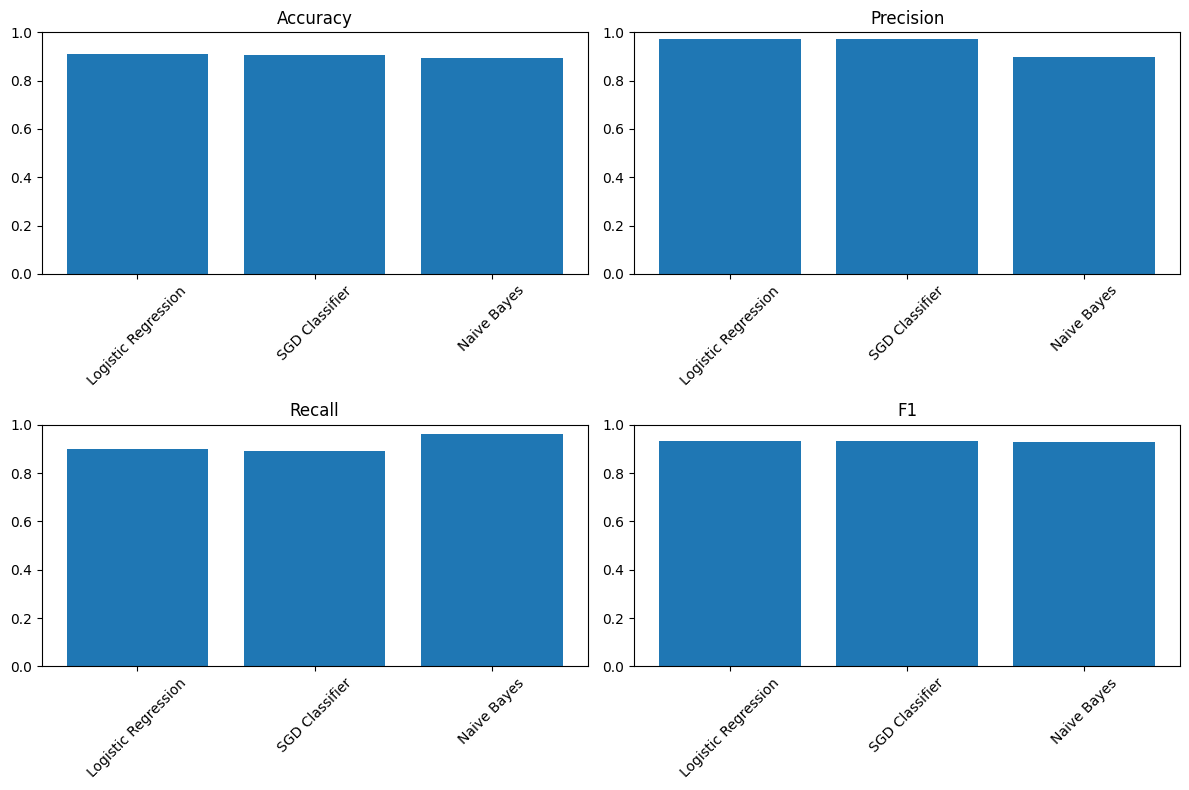

In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt_tab')
#nltk.download('averaged_perceptron_tagger_eng')

class LemmaTokenizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
    
    def get_wordnet_pos(self, treebank_tag):
        """Конвертирует POS-теги Treebank в WordNet"""
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    def __call__(self, doc):
        tokens = nltk.word_tokenize(doc)
        pos_tags = nltk.pos_tag(tokens)
        
        lemmas = []
        for token, tag in pos_tags:
            if token.lower() not in self.stop_words and len(token) > 2:
                wn_tag = self.get_wordnet_pos(tag)
                lemma = self.lemmatizer.lemmatize(token.lower(), wn_tag)
                lemmas.append(lemma)
        
        return lemmas

def load_data(filepath):
    df = pd.read_csv(filepath, engine='python', on_bad_lines='skip')
    df = df[['text', 'labels']].dropna()
    df = df[df['text'].str.len() > 0]
    return df

def simple_text_clean(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    return text.lower().strip()

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }

def plot_metrics(metrics_df):
    plt.figure(figsize=(12, 8))
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.bar(metrics_df['Model'], metrics_df[metric])
        plt.title(metric)
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

def grid_search_wrapper(model, param_grid, X_train, y_train):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=3,
        n_jobs=1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    return gs.best_estimator_, gs.best_params_

def main():  
    df = load_data('C:/Users/ekrosz/Desktop/Лабы/TRAIN.csv')
    df['cleaned_text'] = df['text'].apply(simple_text_clean)
    
    le = LabelEncoder()
    df['labels'] = le.fit_transform(df['labels'])
    
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_text'],
        df['labels'],
        test_size=0.15,
        random_state=42,
        stratify=df['labels']
    )
    
    tfidf = TfidfVectorizer(
        tokenizer=LemmaTokenizer(),
        token_pattern=None,
        #stop_words='english',
        max_features=5000,
        min_df=5,
        max_df=0.7
    )
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    models_params = {
        'Logistic Regression': {
            'model': LogisticRegression(class_weight='balanced', random_state=42),
            'params': {
                'C': [0.5, 1, 2, 4],
                'solver': ['sag', 'liblinear']
            }
        },
        'SGD Classifier': {
            'model': SGDClassifier(class_weight='balanced', random_state=42),
            'params': {
                'loss': ['log_loss', 'modified_huber'],
                'alpha': [0.0001, 0.001, 0.01]
            }
        },
        'Naive Bayes': {
            'model': MultinomialNB(),
            'params': {
                'alpha': [0.05, 0.1, 0.5, 1]
            }
        }
    }
    
    metrics = []
    best_params = {}
    
    for name, mp in models_params.items():
        print(f"\n=== Подбор параметров для {name} ===")
        
        best_model, params = grid_search_wrapper(
            mp['model'],
            mp['params'],
            X_train_tfidf,
            y_train
        )
        
        best_params[name] = params
        
        model_metrics = evaluate_model(best_model, X_test_tfidf, y_test)
        model_metrics['Model'] = name
        metrics.append(model_metrics)
        
        print(f"\nЛучшие параметры для {name}:")
        print(params)
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, best_model.predict(X_test_tfidf)))

        if name != 'Naive Bayes':
            feature_names = tfidf.get_feature_names_out()
            coefs = best_model.coef_[0]
            top_positive = sorted(zip(coefs, feature_names), reverse=True)[:10]
            top_negative = sorted(zip(coefs, feature_names))[:10]
            
            print("\nTop 10 положительных признаков:")
            print([word for _, word in top_positive])
            print("\nTop 10 отрицательных признаков:")
            print([word for _, word in top_negative])
    
    metrics_df = pd.DataFrame(metrics)
    print("\nСравнение моделей:")
    print(metrics_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']])
    
    plot_metrics(metrics_df)

main()